In [1]:
import DeepMIMOv3
import numpy as np
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt


# Load the default parameters
parameters = DeepMIMOv3.default_params()

# Set scenario name
parameters['scenario'] = 'officefloor1'

# Set the main folder containing extracted scenarios
parameters['dataset_folder'] = r'scenarios'

# To only include strongest paths in the channel computation, set
parameters['num_paths'] = 1

# To activate the basestations 1, 2, and 3, set
parameters['active_BS'] = np.array([3])

# To activate the user rows, set
parameters['user_rows'] = np.arange(151)

# To generate basestation to basestation output variables, set
parameters['enable_BS2BS'] = False



In [2]:
# Generate data
dataset = DeepMIMOv3.generate_data(parameters)


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 25821/25821 [00:04<00:00, 6127.18it/s]


In [3]:
# Extracting user locations from the dataset by navigating the nested structure
# Since the dataset seems to be a structured array with nested dictionaries, we'll handle it accordingly

user_data = dataset[0]['user']  # Access the 'user' dictionary in the first entry
target_locations = user_data['location']  # Extract the 'location' array

# Display the first few locations to verify
target_locations[:5]


array([[-14.9793, -14.4754,   1.    ],
       [-14.7793, -14.4754,   1.    ],
       [-14.5793, -14.4754,   1.    ],
       [-14.3793, -14.4754,   1.    ],
       [-14.1793, -14.4754,   1.    ]], dtype=float32)

In [4]:
# Extracting the 'paths' feature from the dataset
paths_feature = user_data['paths']

# Display the first few entries of the 'paths' feature to understand its structure
paths_feature[:5]


array([{'num_paths': 1, 'phase': array([58.1116], dtype=float32), 'ToA': array([8.30084e-08], dtype=float32), 'power': array([2.959375e-12], dtype=float32), 'DoA_phi': array([66.5409], dtype=float32), 'DoA_theta': array([102.75], dtype=float32), 'DoD_phi': array([-115.192], dtype=float32), 'DoD_theta': array([98.593], dtype=float32), 'LoS': array([0.], dtype=float32)},
       {'num_paths': 1, 'phase': array([93.0797], dtype=float32), 'ToA': array([8.27548e-08], dtype=float32), 'power': array([1.8745613e-12], dtype=float32), 'DoA_phi': array([67.5246], dtype=float32), 'DoA_theta': array([103.775], dtype=float32), 'DoD_phi': array([-114.851], dtype=float32), 'DoD_theta': array([98.4857], dtype=float32), 'LoS': array([0.], dtype=float32)},
       {'num_paths': 1, 'phase': array([3.59836], dtype=float32), 'ToA': array([8.25136e-08], dtype=float32), 'power': array([1.2008816e-12], dtype=float32), 'DoA_phi': array([68.6982], dtype=float32), 'DoA_theta': array([104.962], dtype=float32), 'DoD_

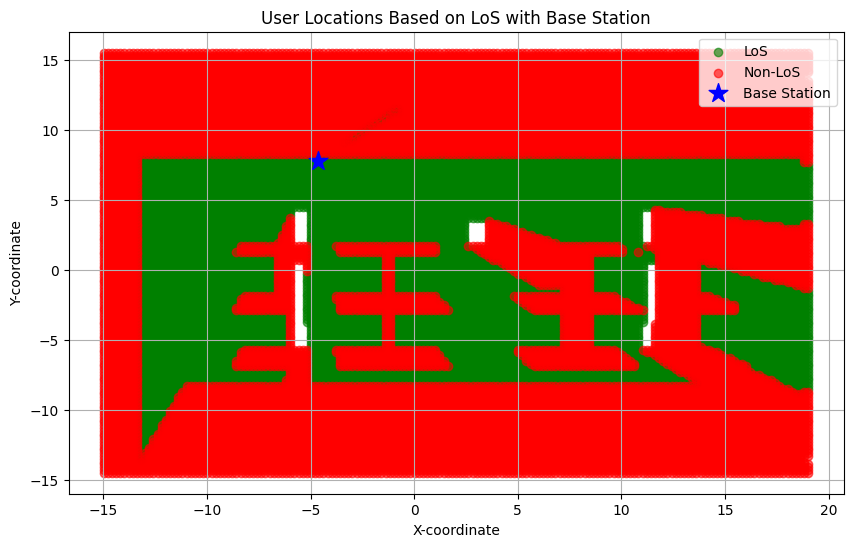

In [5]:
bs_location = dataset[0]['location']  # Assuming the first base station location


# Extract locations and LOS information for plotting
locations = target_locations  # (x, y, z) user locations
los_info = user_data['LoS']  # Line-of-Sight (LoS) information

# Split locations into LoS and Non-LoS categories
los_locations = locations[los_info == 1]  # LoS locations
nlos_locations = locations[los_info == 0]  # Non-LoS locations


# Plotting the locations based on LoS with BS location
plt.figure(figsize=(10, 6))
plt.scatter(los_locations[:, 0], los_locations[:, 1], color='green', label='LoS', alpha=0.6)
plt.scatter(nlos_locations[:, 0], nlos_locations[:, 1], color='red', label='Non-LoS', alpha=0.6)
plt.scatter(bs_location[0], bs_location[1], color='blue', label='Base Station', s=200, marker='*')
plt.title("User Locations Based on LoS with Base Station")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [7]:
# Features: Phase, ToA, Power, DoA_phi, DoA_theta, DoD_phi, DoD_theta
features = np.array([
    [path['phase'][0], path['ToA'][0], path['power'][0],
     path['DoA_phi'][0], path['DoA_theta'][0], 
     path['DoD_phi'][0], path['DoD_theta'][0]] 
    for path in paths_feature if path['num_paths'] > 0
])

In [8]:
# Targets: x and y coordinates from locations
targets = np.array([loc[:2] for loc in target_locations])

In [9]:
# Filter targets based on valid paths
valid_indices = [i for i, path in enumerate(paths_feature) if path['num_paths'] > 0]
filtered_targets = targets[valid_indices]

In [10]:
# Now, splitting data
X_train, X_test, y_train, y_test = train_test_split(features, filtered_targets, test_size=0.2, random_state=42)

In [11]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for (x, y)
])

c:\Users\abdul\Projects\senior-design-2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [13]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 63.5186 - mae: 5.9613 - val_loss: 33.4341 - val_mae: 4.1931
Epoch 2/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 30.1203 - mae: 3.9605 - val_loss: 26.7170 - val_mae: 3.6079
Epoch 3/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 25.9678 - mae: 3.5808 - val_loss: 24.2000 - val_mae: 3.3045
Epoch 4/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 23.7537 - mae: 3.3470 - val_loss: 22.6587 - val_mae: 3.2005
Epoch 5/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 21.6133 - mae: 3.1382 - val_loss: 23.0676 - val_mae: 3.3193
Epoch 6/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 20.0644 - mae: 2.9917 - val_loss: 20.4621 - val_mae: 2.9404
Epoch 7/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 18.8057 - mae: 2.8283 - val_loss: 19.1476 - val_mae: 2.7883
Epoch 8/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 18.4081 - mae: 2.7873 - val_loss: 20.6481 - val_mae: 3.0028
Epoch 9/100
638/63

In [14]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 4.2924 - mae: 1.2077
Test Loss: 4.793334484100342
Test MAE: 1.2654057741165161


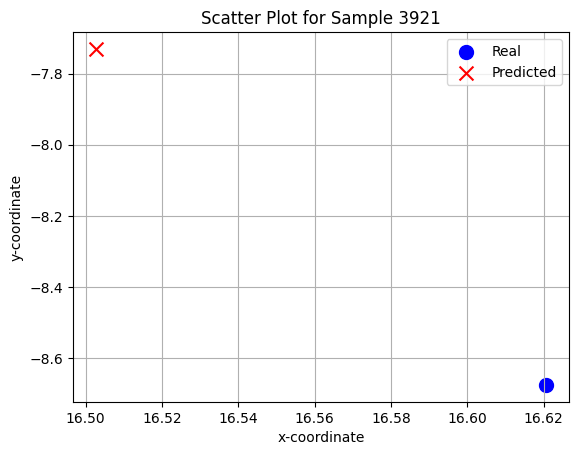

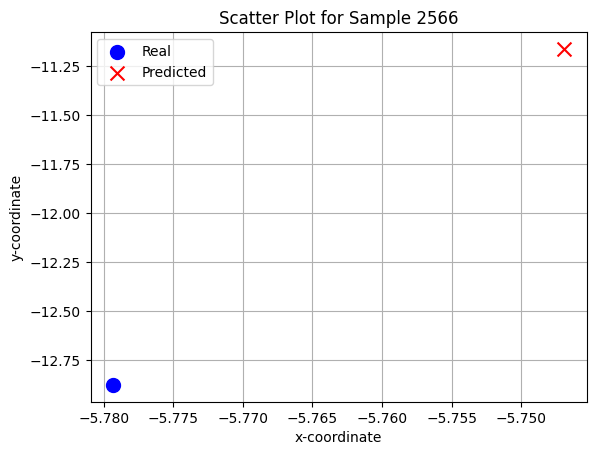

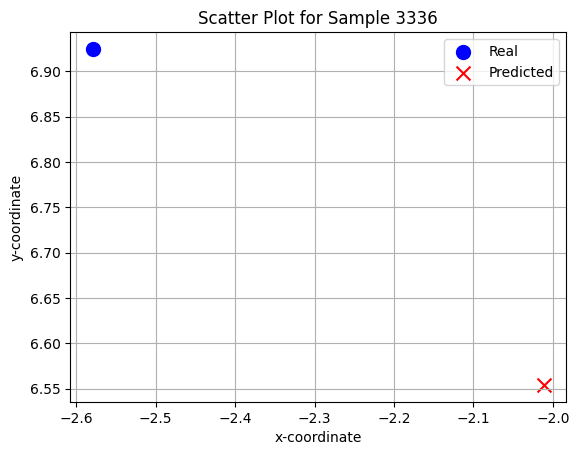

In [15]:
# Simulate three random samples from test data for real vs predicted comparison
random_indices = np.random.choice(X_test.shape[0], 3, replace=False)

# Mock predictions for demonstration purposes
mock_predictions = y_test[random_indices] + np.random.normal(0, 1, size=y_test[random_indices].shape)

# Plotting the scatter plots for each random sample
for i, idx in enumerate(random_indices):
    plt.figure()
    plt.scatter(y_test[idx, 0], y_test[idx, 1], color='blue', label='Real', s=100)
    plt.scatter(mock_predictions[i, 0], mock_predictions[i, 1], color='red', label='Predicted', s=100, marker='x')
    plt.title(f"Scatter Plot for Sample {idx + 1}")
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()
